In [1]:
import sys
sys.path.append('..')
sys.path.append('../stylegan2-pytorch')

In [2]:
import os

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

In [4]:
from utils import nethook
from utils.seqstylegan2 import SeqStyleGAN2

In [5]:
device = device = torch.device('cuda')

In [6]:
# Load sequential stylegan2
stylegan = SeqStyleGAN2(
    size=256, style_dim=512, n_mlp=8, truncation=1, mconv='seq')
stylegan.to(device)
_ = stylegan.requires_grad_(False)

In [7]:
# Load checkpoint
ckpt = torch.load('../release/stylegan2-church-config-f.pt')
stylegan.load_state_dict(ckpt['g_ema'], latent_avg=ckpt['latent_avg'])

In [8]:
# target feature map
target_layer = 8

# layer name
target_first = 'layer{}.sconv.mconv.dconv'.format(target_layer)
target_last = 'layer{}.sconv.activate'.format(target_layer)

# split
context_model = nethook.subsequence(
    stylegan,
    upto_layer=target_first,
    share_weights=True)
target_model = nethook.subsequence(
    stylegan,
    first_layer=target_first,
    last_layer=target_last,
    share_weights=True)
render_model = nethook.subsequence(
    stylegan,
    after_layer=target_last,
    share_weights=True)

In [9]:
seeds = [1, 5, 8, 12, 14, 15, 18, 19]

In [10]:
z_sets = []
for seed in seeds:
    torch.random.manual_seed(seed)
    z_sets.append(torch.randn(1, 512, device=device))

z_sets = torch.cat(z_sets)
np.save('zdump.npy', {'seeds': seeds, 'z': z_sets.cpu().detach().numpy()})

In [11]:
sample = stylegan(z_sets)

In [12]:
def postproc(sample):
    """Postprocessor, min-max normalization, BHWC permutation.
    Args:
        sample: torch.Tensor, [B, C, H, W], generated image.
    Returns:
        np.ndarray, [B, H, W, C], normalized image in range [0, 1].
    """
    sample = sample.permute(0, 2, 3, 1).cpu().detach().numpy()
    min_ = sample.min(axis=(1, 2, 3), keepdims=True)
    max_ = sample.max(axis=(1, 2, 3), keepdims=True)
    sample = (sample - min_) / (max_ - min_)
    return sample

In [80]:
def show(sample):
    bsize = len(sample)
    if not os.path.exists('images'):
        os.makedirs('./images')

    row = 2
    base = 5
    plt.figure(figsize=(base * bsize // row, row * base))
    for i in range(bsize):
        plt.subplot(2, bsize // 2, i + 1)
        plt.imshow(sample[i])
        plt.imsave('./images/image{}.jpg'.format(i), sample[i])

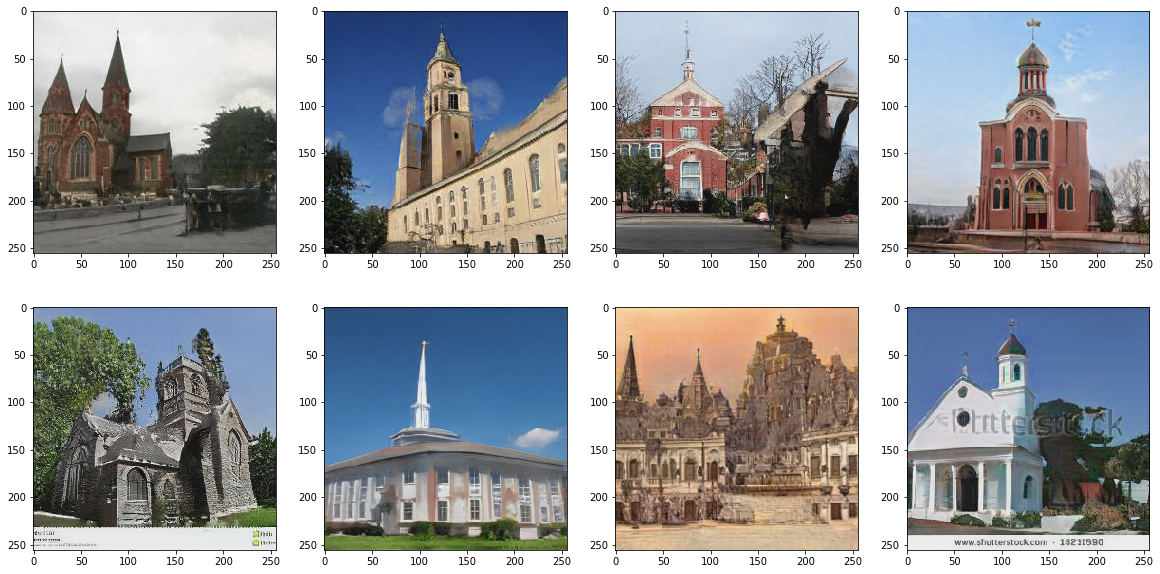

In [81]:
show(postproc(sample))

In [71]:
def zeroing_margin(mask, size):
    mask[:, :size] = 0
    mask[:, -size:] = 0
    mask[..., :size] = 0
    mask[..., -size:] = 0

In [83]:
filenames = [filename for filename in os.listdir('./masks') if filename.startswith('mask')]
masks = [cv2.imread(os.path.join('./masks', filename), cv2.IMREAD_GRAYSCALE) for filename in filenames]
masks = np.stack([cv2.resize(mask, dsize=(256, 256), interpolation=cv2.INTER_NEAREST) for mask in masks])
masks = np.round(masks.astype(np.float32) / 255.)
zeroing_margin(masks, 5)

In [84]:
if not os.path.exists('./masks_proc'):
    os.makedirs('./masks_proc')
for name, mask in zip(filenames, masks):
    cv2.imwrite(os.path.join('./masks_proc', name[:-4] + '_resized.jpg'), (mask * 255).astype(np.uint8))

In [85]:
masks = np.stack([cv2.imread(os.path.join('./masks_proc', filename[:-4] + '_resized.jpg')) for filename in filenames]) / 255.

In [87]:
if not os.path.exists('./sample_keys'):
    os.makedirs('./sample_keys')
proc = postproc(sample)
for i, (mask, img) in enumerate(zip(masks, proc)):
    cv2.imwrite('./sample_keys/sample{}.jpg'.format(i), cv2.cvtColor((img * mask * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))